#  Pathway Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to both prune the number of genes/features as well as a source of pathway information to encorporate into layer design.

In [123]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# fix random seed for reproducibility
np.random.seed(42)

# See https://github.com/h5py/h5py/issues/712
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" 

## Load TCGA+TARGET+GTEX

Load expression and create a one hot output vector

In [3]:
X = pd.read_hdf("data/tcga_target_gtex.h5", "expression")
X.head()

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,-9.966042,-9.965816,-9.965880,4.4595,0.9343,-5.0116,7.5126,0.8164,-2.1140,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,5.326995,-9.9658
GTEX-1117F-0426-SM-5EGHI,-9.966042,-9.965816,-9.965880,1.1512,-1.2828,-6.5064,6.0777,-2.3147,0.5568,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,3.037565,-9.9658
GTEX-1117F-0526-SM-5EGHJ,-9.966042,-9.965816,-9.965880,5.2411,0.8488,-6.5064,10.0319,0.1257,-1.1172,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,4.302417,-9.9658
GTEX-1117F-0626-SM-5N9CS,-9.966042,-9.965816,-9.965880,5.4758,2.6325,-9.9658,9.7572,1.7702,-1.8836,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,4.248770,-9.9658
GTEX-1117F-0726-SM-5GIEN,-9.966042,-9.965816,-0.833902,4.5534,1.3051,-9.9658,7.7931,-0.0725,-2.2447,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,3.145838,-9.9658


In [4]:
Y = pd.read_hdf("data/tcga_target_gtex.h5", "labels")
Y.head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal
id,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0426-SM-5EGHI,Muscle - Skeletal,Muscle - Skeletal,Muscle,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0526-SM-5EGHJ,Artery - Tibial,Artery - Tibial,Blood Vessel,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0626-SM-5N9CS,Artery - Coronary,Artery - Coronary,Blood Vessel,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0726-SM-5GIEN,Heart - Atrial Appendage,Heart - Atrial Appendage,Heart,Normal Tissue,Female,GTEX,Normal


## Ingest Pathways

Load gene sets downloaded from msigdb filter out data to only include gene's present in the union of all the pathways

In [173]:
# Load gene sets from downloaded MSigDB gmt file
# KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = {line.strip().split("\t")[0]: line.strip().split("\t")[2:]
                 for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop  genes not in X - sort so order is the same as X_pruned.columns
gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values])
             for name, genes in gene_sets.items()}

# Find union of all gene's in all gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X to only include genes in the gene sets
X_pruned = X.drop(labels=(set(X.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19126, 5172)


## Wrangle Labels

Convert tumor/normal, primary site and disease into one hot outputs and combine into a single multi-class multi-label output vectoro to train against.

In [65]:
# Convert  primary_site into numerical values for one-hot multi-class training
from sklearn.preprocessing import LabelEncoder

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(
    tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index)

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(
    primary_site_encoder.fit_transform(Y["primary_site"]), index=Y.index)

disease_encoder = LabelEncoder()
Y["disease_value"] = pd.Series(
    disease_encoder.fit_transform(Y["disease"]), index=Y.index)

Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,gender_value,tumor_normal_value,primary_site_value,disease_value
count,19126,19126,19126,19126,19126,19126,19126,19126.000000,19126.000000,19126.000000,19126.000000
unique,93,93,46,16,3,3,2,NaN,NaN,NaN,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN,NaN,NaN,NaN
freq,1212,1212,1846,9185,10453,10534,10530,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.563056,0.550559,20.651992,48.639757
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512406,0.497450,12.419634,25.847654
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,19.000000,51.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,45.000000,92.000000


In [69]:
# Create a multi-class one hot output all four classifications
from keras.utils import np_utils
Y_onehot = np.append(
    Y["tumor_normal_value"].values.reshape(Y.shape[0],-1), 
    np_utils.to_categorical(Y["primary_site_value"]), axis=1)
Y_onehot = np.append(Y_onehot,
    np_utils.to_categorical(Y["disease_value"]), axis=1)
print(Y_onehot.shape)

(19126, 140)


In [89]:
# Check out one-hot compound output vector
for i in range(0,20000,5000):
    y = Y.iloc[i]
    print("{} {} {}".format(y.tumor_normal, y.primary_site, y.disease))
    
    yo = Y_onehot[i]
    print(tumor_normal_encoder.classes_.tolist()[int(yo[0])],
          primary_site_encoder.classes_.tolist()[np.argmax(yo[1:1+46])],
          disease_encoder.classes_.tolist()[np.argmax(yo[1+46:-1])])

Normal Adipose Tissue Adipose - Subcutaneous
Normal Adipose Tissue Adipose - Subcutaneous
Normal Liver Liver
Normal Liver Liver
Tumor Lung Lung Squamous Cell Carcinoma
Tumor Lung Lung Squamous Cell Carcinoma
Tumor Skin Skin Cutaneous Melanoma
Tumor Skin Skin Cutaneous Melanoma


## Stratify Split into Train/Test

Split the data into training and test sets stratified by primary side. Check that we get a good distribution of both primary site and disease between each of these sets.

In [90]:
# Split into stratified training and test sets based primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pruned.values, Y["primary_site_value"]):
    X_train = X_pruned.values[train_index]
    X_test = X_pruned.values[test_index]
    y_train = Y_onehot[train_index]
    y_test = Y_onehot[test_index]
    primary_site_train = Y["primary_site_value"].values[train_index]
    primary_site_test = Y["primary_site_value"].values[test_index]
    disease_train = Y["disease_value"].values[train_index]
    disease_test = Y["disease_value"].values[test_index]

print(X_train.shape, X_test.shape)

(15300, 5172) (3826, 5172)


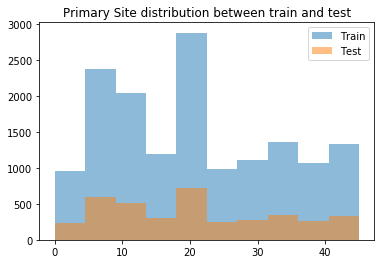

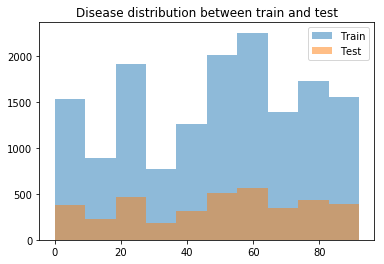

In [124]:
# Lets see how big each class is based on primary site
plt.hist(primary_site_train, alpha=0.5, label='Train')
plt.hist(primary_site_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Primary Site distribution between train and test")
plt.show()

# Lets see how big each class is based on primary site
plt.hist(disease_train, alpha=0.5, label='Train')
plt.hist(disease_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Disease distribution between train and test")
plt.show()

## Multi-label Classification

Label gender, primary site, tumor/normal and disease all at once

In [130]:
%%time
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(128, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),

    # Sigmoid as we have multiple labels
    Dense(y_train.shape[1], activation='sigmoid')
]

model = Sequential(classify)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train, epochs=10, batch_size=128, shuffle="batch", callbacks=callbacks)
print(model.metrics_names, model.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5172)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 5172)              20688     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               662144    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 140)               18060     
Total para

In [113]:
# Save the model for separate inference
with open("models/multi_label.params.json", "w") as f:
    f.write(json.dumps({
        "tumor_normal": tumor_normal_encoder.classes_.tolist(),
        "primary_site": primary_site_encoder.classes_.tolist(),
        "disease": disease_encoder.classes_.tolist(),
        "genes": all_gene_set_genes}))

with open("models/multi_label.model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("models/multi_label.weights.h5")

In [149]:
# Load the model and predict the test set
model = keras.models.model_from_json(open("models/multi_label.model.json").read())
model.load_weights("models/multi_label.weights.h5")
params = json.loads(open("models/multi_label.params.json").read())
predictions = model.predict(X_test)

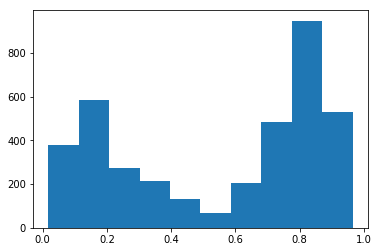

In [150]:
# Plot the distribution of tumor/normal values
plt.hist(predictions[:,0])
plt.show()

Tumor/Normal
[[1577  142]
 [  13 2094]]
Primary Site


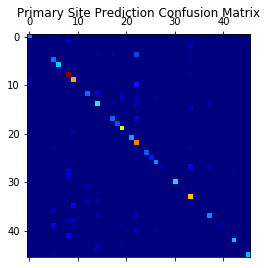

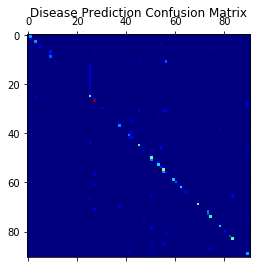

In [158]:
# Plot the confusion matrix for tumor/normal, primary site and disease
from sklearn.metrics import confusion_matrix
print("Tumor/Normal")
print(confusion_matrix(y_test[:,0], np.round(predictions[:,0])))

print("Primary Site")
plt.matshow(confusion_matrix(primary_site_test, 
                             np.array([np.argmax(p) for p in predictions[:,1:1+46]])), 
            cmap='jet')
plt.title("Primary Site Prediction Confusion Matrix")
plt.show()

plt.matshow(confusion_matrix(disease_test, 
                             np.array([np.argmax(p) for p in predictions[:,1+46:-1]])), 
            cmap='jet')
plt.title("Disease Prediction Confusion Matrix")
plt.show()

In [172]:
# Let's eye ball a few predictions compared to the original
for i in range(0,20000,2000):
    print("Original: {} {} {}".format(Y.iloc[i].tumor_normal, Y.iloc[i].primary_site, Y.iloc[i].disease))
    
    prediction = model.predict(X_pruned.iloc[i:i+1])[0]  
    print("Predicted:",
          tumor_normal_encoder.classes_.tolist()[int(round(prediction[0]))],
          primary_site_encoder.classes_.tolist()[np.argmax(prediction[1:1+46])],
          disease_encoder.classes_.tolist()[np.argmax(prediction[1+46:-1])])

Original: Normal Adipose Tissue Adipose - Subcutaneous
Predicted: Normal Skin Adipose - Subcutaneous
Original: Normal Esophagus Esophagus - Mucosa
Predicted: Normal Esophagus Esophagus - Mucosa
Original: Normal Lung Lung
Predicted: Normal Lung Lung
Original: Normal Skin Skin - Sun Exposed (Lower Leg)
Predicted: Normal Skin Skin - Sun Exposed (Lower Leg)
Original: Tumor White blood cell Acute Lymphoblastic Leukemia
Predicted: Tumor White blood cell Acute Myeloid Leukemia
Original: Tumor Lung Lung Squamous Cell Carcinoma
Predicted: Tumor Lung Lung Squamous Cell Carcinoma
Original: Tumor Skin Skin Cutaneous Melanoma
Predicted: Tumor Skin Skin Cutaneous Melanoma
Original: Tumor Liver Liver Hepatocellular Carcinoma
Predicted: Tumor Liver Liver Hepatocellular Carcinoma
Original: Tumor Bladder Bladder Urothelial Carcinoma
Predicted: Tumor Lung Lung Squamous Cell Carcinoma
Original: Tumor Brain Brain Lower Grade Glioma
Predicted: Tumor Brain Brain Lower Grade Glioma


## Primary Site Classification w/Per Pathway Sub-Network Input Layer
For each pathway build a custom input layer that extracts the expression levels for the genes in the pathway from the full input vector and feeds this into a dense single output hidden neuron. These are then aggregated and fed into a standard set of stacked layers and trained to classify tumor/norml and primary site. The hidden per pathway neurons are named after the pathway an 'may' indicate which pathway lead to a given classification.

In [176]:
# Convert list of gene names into list of indexes into  features of X_pruned
gene_set_indexes = {name: np.searchsorted(X_pruned.columns.values, genes)
                    for name, genes in gene_sets.items()}
print("Pathway KEGG_ABC_TRANSPORTERS Gene Indexes:",
      gene_set_indexes["KEGG_ABC_TRANSPORTERS"])

Pathway KEGG_ABC_TRANSPORTERS Gene Indexes: [  20   49   43   35   11 4693   19 4692   18   30   12   46   16   25
   45   15   36   34   40   37   42   48   38   39   13   47   26  848
   23   32   44   28   29   21   17   41   33   24   31   14   22   27
   50   51]


In [177]:
%%time
from keras.models import Model, Sequential
from keras.layers import Input, Lambda, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.merge import concatenate
from keras import backend as K
import itertools

main_input = Input(shape=(X_train.shape[1],), name="main_input")

"""
Build per pathway sub-networks
"""
# Set to a small number (~4) for debugging, set to None to build all pathways
# max_num_pathways = 4
max_num_pathways = None

# Extract features/gene's for each pathway from the aggregate x input vector
pathways = [Lambda(lambda x:
                   K.concatenate([x[:, i:i+1] for i in indexes]))(main_input)
            for name, indexes in
            itertools.islice(gene_set_indexes.items(), max_num_pathways)]

# Add a dense hidden layer per pathway with width proportional to the
# number of genes in the pathway
# pathways = [Dense(max(2, len(i)//4), activation='relu')(p)
#             for p, i in zip(pathways, gene_set_indexes.values())]

# Add a named binary output for each pathway
# pathways = [Dense(1, activity_regularizer=regularizers.l1(1e-5),
#                   activation='relu', name=name)(p)
#             for p, name in zip(pathways, gene_set_indexes.keys())]

pathways = [Dropout(0.5)(Dense(1, activity_regularizer=regularizers.l1(1e-5), 
                               activation='relu', name=name)(p))
            for p, name in zip(pathways, gene_set_indexes.keys())]

# Concatenate binary outputs of each of  sub-networks back into single vector
x = keras.layers.concatenate(pathways)

"""
Add traditional stacked network for final multi-label classification
"""
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(8, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(y_train.shape[1], activation='sigmoid')(x)

model = Model(inputs=[main_input], outputs=[x])
# print(model.summary())  # Too detailed when building full set of pathways
print("Trainable params::", np.sum(
    [np.product(v.shape) for v in model.trainable_weights]).value)

Trainable params:: 17449
CPU times: user 1min 34s, sys: 1.76 s, total: 1min 35s
Wall time: 1min 36s


In [178]:
%%time
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="data/logs/{}".format(time()))

epochs = 10
batch_size = 128

print("Compiling and training...")
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
          shuffle="batch",
          callbacks=[EarlyStopping(monitor='acc', min_delta=0.05,
                                   patience=2, verbose=2, mode="max"),
                     tensorboard])
print(model.metrics_names, model.evaluate(X_test, y_test))

Compiling and training...
Epoch 1/10
15300/15300 [==============================] - 40s 3ms/step - loss: 0.8467 - acc: 0.7680
Epoch 2/10
15300/15300 [==============================] - 16s 1ms/step - loss: 0.3000 - acc: 0.9397
Epoch 3/10
15300/15300 [==============================] - 16s 1ms/step - loss: 0.1783 - acc: 0.9797
Epoch 4/10
15300/15300 [==============================] - 16s 1ms/step - loss: 0.1529 - acc: 0.9821
Epoch 00004: early stopping
3826/3826 [==============================] - 28s 7ms/step
['loss', 'acc'] [0.08653967046279654, 0.9825050429841703]
CPU times: user 5min 40s, sys: 1min 44s, total: 7min 24s
Wall time: 3min 17s


## Compare to Treehouse
Run the classifier on Treehouse public compendium samples and compare its predicted lables. In addition see if the top activated pathway is in the top implicated pathways using Treehouse protocol output artifacts.

In [191]:
X_treehouse = pd.read_hdf("data/treehouse.h5", "expression")
Y_treehouse = pd.read_hdf("data/treehouse.h5", "labels")

X_treehouse_pruned = X_treehouse.drop(labels=(set(X_treehouse.columns) - set(all_gene_set_genes)), 
                                      axis=1, errors="ignore")

Y_treehouse["primary_site_predicted"] = [", ".join(["{}({:0.2f})".format(primary_site_encoder.classes_.tolist()[i], 
                                                                         p[1:1+46][i]) 
                                                    for i in p[1:1+46].argsort()[-3:][::-1]]) 
                                         for p in model.predict(X_treehouse_pruned)]
Y_treehouse.iloc[0:500:25].head()


#         "tumor_normal": tumor_normal_encoder.classes_.tolist(),
#         "primary_site": primary_site_encoder.classes_.tolist(),
#         "disease": disease_encoder.classes_.tolist(),
#         "genes": all_gene_set_genes}))

#     print("Predicted:",
#           tumor_normal_encoder.classes_.tolist()[int(round(prediction[0]))],
#           primary_site_encoder.classes_.tolist()[np.argmax(prediction[1:1+46])],
#           disease_encoder.classes_.tolist()[np.argmax(prediction[1+46:-1])])


,age_in_years,gender,disease,primary_site_predicted
id,,,,
TH01_0051_S01,nan,Not Reported,Hepatoblastoma,"Brain(0.11), Lung(0.08), Breast(0.07)"
TH01_0135_S01,nan,Not Reported,Lymphoma,"Brain(0.13), Lung(0.10), Breast(0.09)"
TH03_0020_S01,16,Male,Medulloblastoma,"Brain(0.16), Lung(0.13), Breast(0.12)"
TH03_0143_S02,17,Male,Osteosarcoma,"Brain(0.17), Lung(0.13), Breast(0.13)"
TH06_0613_S02,0,Male,Atypical Teratoid/Rhabdoid Tumor,"Brain(0.15), Lung(0.12), Breast(0.11)"


In [186]:
Y_treehouse.iloc[0:500:100].head()

,age_in_years,gender,disease,primary_site_predicted
id,,,,
TH01_0051_S01,nan,Not Reported,Hepatoblastoma,"Adipose Tissue(0.56), Breast(0.11), Lymphatic ..."
TH06_0613_S02,0,Male,Atypical Teratoid/Rhabdoid Tumor,"Adipose Tissue(0.55), Breast(0.15), Lymphatic ..."
THR09_0224_S01,4,Male,Lymphoma,"Adipose Tissue(0.54), Breast(0.17), Lymphatic ..."
THR14_0302_S01,6.8,Female,Glioma,"Adipose Tissue(0.56), Breast(0.09), Lymphatic ..."
THR19_0434_S01,11,Female,Glioma,"Adipose Tissue(0.57), Breast(0.07), Lymphatic ..."
